In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack

In [2]:
# Load the data 
df = pd.read_csv('US_only.csv')
df.fillna("missing", inplace = True)
df = df[['company_profile', 'description', 'requirements', 'benefits',
         'employment_type','telecommuting', 'has_company_logo',
         'required_experience', 'required_education', 'state', 'industry', 'function',
         'fraudulent']]  

In [3]:
# Step 1: Define a custom preprocessor function to remove numbers from text columns
def remove_numbers(text):
    return re.sub(r'\d+', '', text)  # Remove any sequence of digits

In [4]:
# Step 2: Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df.drop('fraudulent', axis=1), df['fraudulent'], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# Step 3: Initialize TfidfVectorizer for each text column (apply only to the training data)
vectorizer_profile = TfidfVectorizer(max_features=100, stop_words='english', preprocessor=remove_numbers)
vectorizer_description = TfidfVectorizer(max_features=100, stop_words='english', preprocessor=remove_numbers)
vectorizer_requirements = TfidfVectorizer(max_features=100, stop_words='english', preprocessor=remove_numbers)
vectorizer_benefits = TfidfVectorizer(max_features=100, stop_words='english', preprocessor=remove_numbers)

# Fit on the training data and transform each text column
X_train_profile_tfidf = vectorizer_profile.fit_transform(X_train['company_profile'].fillna('missing description'))
X_train_description_tfidf = vectorizer_description.fit_transform(X_train['description'].fillna('missing description'))
X_train_requirements_tfidf = vectorizer_requirements.fit_transform(X_train['requirements'].fillna('missing description'))
X_train_benefits_tfidf = vectorizer_benefits.fit_transform(X_train['benefits'].fillna('missing description'))

In [7]:
# Step 4: Transform the validation and test sets based on the fitted vectorizers
X_val_profile_tfidf = vectorizer_profile.transform(X_val['company_profile'].fillna('missing description'))
X_val_description_tfidf = vectorizer_description.transform(X_val['description'].fillna('missing description'))
X_val_requirements_tfidf = vectorizer_requirements.transform(X_val['requirements'].fillna('missing description'))
X_val_benefits_tfidf = vectorizer_benefits.transform(X_val['benefits'].fillna('missing description'))

X_test_profile_tfidf = vectorizer_profile.transform(X_test['company_profile'].fillna('missing description'))
X_test_description_tfidf = vectorizer_description.transform(X_test['description'].fillna('missing description'))
X_test_requirements_tfidf = vectorizer_requirements.transform(X_test['requirements'].fillna('missing description'))
X_test_benefits_tfidf = vectorizer_benefits.transform(X_test['benefits'].fillna('missing description'))

In [8]:
# Step 5: One-Hot Encode the categorical features
categorical_columns = ['telecommuting', 'has_company_logo','employment_type',
                       'required_experience', 'required_education', 'state', 'industry', 'function']
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)

# Fit the OneHotEncoder on the training categorical features and transform them
X_train_categorical = onehot_encoder.fit_transform(X_train[categorical_columns].fillna('Unknown'))
X_val_categorical = onehot_encoder.transform(X_val[categorical_columns].fillna('Unknown'))
X_test_categorical = onehot_encoder.transform(X_test[categorical_columns].fillna('Unknown'))

C:\Users\guanq\anaconda3\envs\DeepLearningClass\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
# Step 6: Combine the TF-IDF features and the one-hot encoded categorical features
X_train_combined = hstack([X_train_profile_tfidf, X_train_description_tfidf, X_train_requirements_tfidf, 
                           X_train_benefits_tfidf,X_train_categorical])
X_val_combined = hstack([X_val_profile_tfidf, X_val_description_tfidf, X_val_requirements_tfidf, 
                         X_val_benefits_tfidf, X_val_categorical])
X_test_combined = hstack([X_test_profile_tfidf, X_test_description_tfidf, X_test_requirements_tfidf, 
                          X_test_benefits_tfidf,X_test_categorical])

In [10]:
# Step 7: Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification problem
    eval_metric='logloss',        # Log loss as the evaluation metric
    use_label_encoder=False,      # Prevent label encoder warning
    random_state=42               # Ensure reproducibility
)

# Train the model on the combined training data (TF-IDF + categorical)
xgb_model.fit(X_train_combined, y_train)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val_combined)
y_val_prob = xgb_model.predict_proba(X_val_combined)[:, 1]

In [11]:
# Step 8: Print a classification report for the validation set
print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1999
           1       0.93      0.73      0.82       132

    accuracy                           0.98      2131
   macro avg       0.96      0.87      0.91      2131
weighted avg       0.98      0.98      0.98      2131



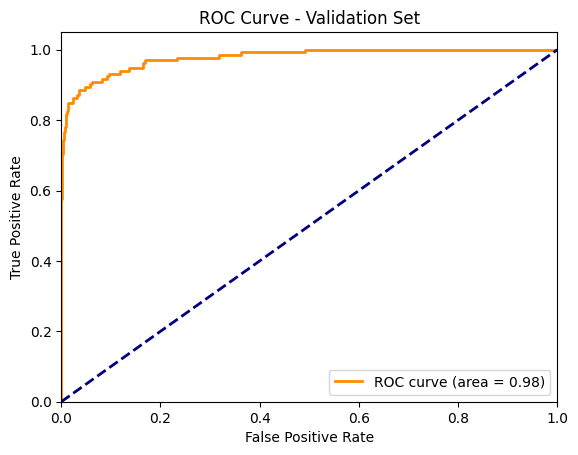

In [12]:
# Step 9: Plot the ROC curve for validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.show()

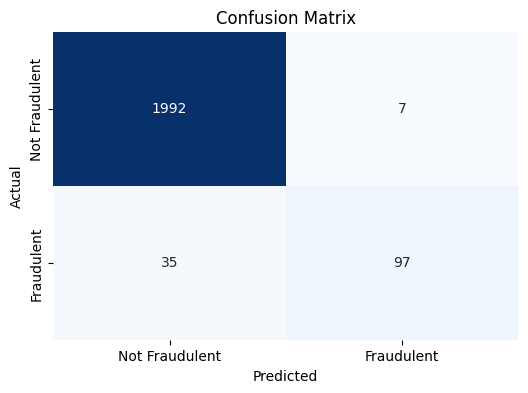

In [13]:
# Step 10: Confusion matrix for validation set
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraudulent', 'Fraudulent'],
            yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1981
           1       0.94      0.75      0.83       151

    accuracy                           0.98      2132
   macro avg       0.96      0.87      0.91      2132
weighted avg       0.98      0.98      0.98      2132



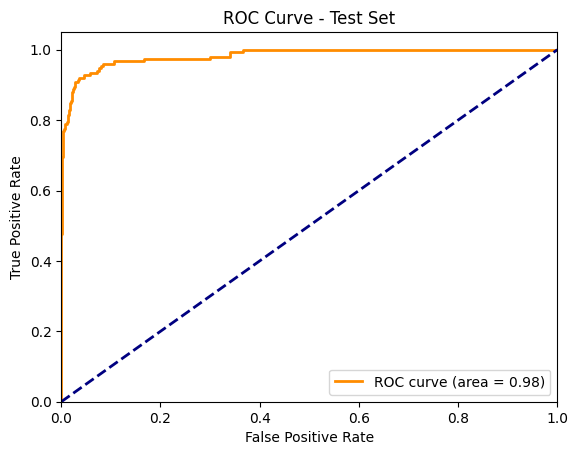

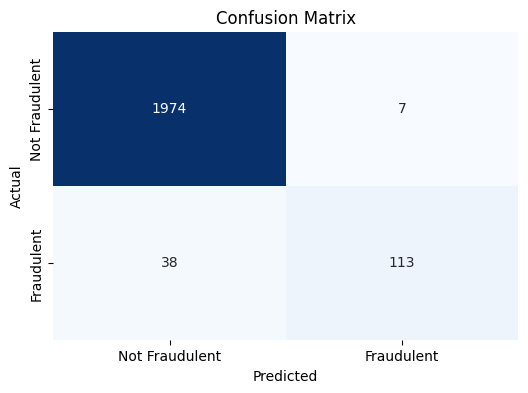

In [14]:
# Repeat similar steps for the test set

# Predict on the test set
y_test_pred = xgb_model.predict(X_test_combined)
y_test_prob = xgb_model.predict_proba(X_test_combined)[:, 1]

# Step 8: Print a classification report for the test set
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))

# Step 9: Plot the ROC curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")
plt.show()

# Step 10: Confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraudulent', 'Fraudulent'],
            yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()